In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ASNA-hackathon/sample_submission.csv
/kaggle/input/ASNA-hackathon/train.csv
/kaggle/input/ASNA-hackathon/test.csv


In [2]:
#Importing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
import lightgbm as lgb
from lightgbm import LGBMClassifier
from statistics import mean

In [3]:
df_train = pd.read_csv("/kaggle/input/ASNA-hackathon/train.csv") #7290
df_test = pd.read_csv("/kaggle/input/ASNA-hackathon/test.csv") #1844

In [4]:
df_train['Claim over 1k'].value_counts()

Claim over 1k
0    6458
1     832
Name: count, dtype: int64

In [5]:
df_train['Income'].replace(0, np.nan, inplace=True)
df_test['Income'].replace(0, np.nan, inplace=True)

/tmp/ipykernel_17/2961618207.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Income'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_17/2961618207.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [6]:
for c in df_train.columns:
    col_type = df_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_train[c] = df_train[c].astype('category')
        
for c in df_test.columns:
    col_type = df_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_test[c] = df_test[c].astype('category')

In [7]:
# X = df_train.drop(["Claim over 1k"], axis=1)
# Y = df_train["Claim over 1k"]
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify = Y)

In [8]:
cols_with_missing = [col for col in df_train.columns 
                                 if df_train[col].isnull().any()]                                  
candidate_train_predictors = df_train.drop(['CustomerID', 'Claim over 1k', 'Coverage Index', 'Education Index', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size Index'] + cols_with_missing, axis=1)
candidate_test_predictors = df_test.drop(['CustomerID', 'Coverage Index', 'Education Index', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size Index'] + cols_with_missing, axis=1)

# "cardinality" means the number of unique values in a column.
# We use it as our only way to select categorical columns here. This is convenient, though
# a little arbitrary.
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].nunique() < 10 and
                                candidate_train_predictors[cname].dtype == "object"]
numeric_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]

In [9]:
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_training_predictors

,Customer Lifetime Value,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Renew Offer Type
0,3622.69,4,107,3,1,3
1,10610.21,26,14,0,7,1
2,13868.02,11,38,0,3,3
3,3119.69,16,32,0,1,2
4,5999.04,45,126,0,1,2
...,...,...,...,...,...,...
7285,27500.54,0,28,1,2,1
7286,11750.03,9,107,0,2,3
7287,7757.04,23,119,0,9,1
7288,3465.16,19,89,0,1,3


In [10]:
y = df_train['Claim over 1k']
X = one_hot_encoded_training_predictors
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

Lets try Random Forest Classifier Model

In [11]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced')
rf.fit(train_X,train_y)
val_y_predrf = rf.predict(val_X)

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predrf, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
print('Recall of RF on test set: {:.2f}'.format(recall_score(val_y, val_y_predrf, average='binary'))) 
print('Precision of RF on test set: {:.2f}'.format(precision_score(val_y, val_y_predrf))) 
print('F1 score of RF on test set: {:.2f}'.format(f1_score(val_y, val_y_predrf, average='weighted'))) # to account for disbalance
precision, recall, _ = precision_recall_curve(val_y, val_y_predrf)
auc_pr = auc(recall, precision)

precision, recall, _ = metrics.precision_recall_curve(val_y, val_y_predrf)
auc_pr = metrics.auc(recall, precision)

print(f"ROC-AUC of RF on test set: {auc_roc}")
print(f"PR-AUC of RF on test set: {auc_pr}")

Recall of RF on test set: 0.31
Precision of RF on test set: 0.74
F1 score of RF on test set: 0.89
ROC-AUC of RF on test set: 0.6500132849171907
PR-AUC of RF on test set: 0.5674247113527964


Lets try BalancedRandom Forest Classifier which can automatically handle imbalanced dataset

In [13]:
# BalancedRandomForestClassifier
BRFC = BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced')
BRFC.fit(train_X,train_y)
val_y_predbrf = BRFC.predict(val_X)

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


In [14]:
fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predbrf, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predbrf)
auc_pr = auc(recall, precision)

print("Recall of BRF on test set:",metrics.recall_score(val_y, val_y_predbrf,average='binary')) 
print('Precision of BRF on test set: {:.2f}'.format(precision_score(val_y, val_y_predbrf))) 
print('F1 score of BRF on test set: {:.2f}'.format(f1_score(val_y, val_y_predbrf, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of BRF on test set: {auc_roc}")
print(f"PR-AUC of BRF on test set: {auc_pr}")

Recall of BRF on test set: 0.7428571428571429
Precision of BRF on test set: 0.28
F1 score of BRF on test set: 0.80
ROC-AUC of BRF on test set: 0.7499158621911257
PR-AUC of BRF on test set: 0.5285750893604315


Lets try XgBoost classifier model

In [15]:
# XgBoost
xgb = xgboost.XGBClassifier()
xgb.fit(train_X, train_y)
val_y_predxg = xgb.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predxg, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predxg)
auc_pr = auc(recall, precision)

print("Recall of XGB on test set:",metrics.recall_score(val_y, val_y_predxg,average='binary')) 
print('Precision of XGB on test set: {:.2f}'.format(precision_score(val_y, val_y_predxg))) 
print('F1 score of XGB on test set: {:.2f}'.format(f1_score(val_y, val_y_predxg, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of XGB on test set: {auc_roc}")
print(f"PR-AUC of XGB on test set: {auc_pr}")

Recall of XGB on test set: 0.3904761904761905
Precision of XGB on test set: 0.65
F1 score of XGB on test set: 0.90
ROC-AUC of XGB on test set: 0.6815989135889942
PR-AUC of XGB on test set: 0.5557418871735932


We will also try LightGBM classifier and see if there are any improvements.

In [16]:
y = df_train['Claim over 1k']
X = candidate_train_predictors
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

In [17]:
lgbm = LGBMClassifier(objective='binary')
lgbm.fit(train_X,train_y)
val_y_predlgbm = lgbm.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
Recall of LightGBM on test set: 0.5
Precision of LightGBM on test set: 0.69
F1 score of LightGBM on test set: 0.91
ROC-AUC of LightGBM on test set: 0.7356811145510836
PR-AUC of LightGBM on test set: 0.6242969821673525


Feature importance

In [18]:
# import shap
# explainer = shap.Explainer(lgbm)
# shap_values = explainer.shap_values(val_X)
# shap.summary_plot(shap_values[1], val_X, max_display=15)

In [19]:
# import numpy as np
# vals= np.abs(shap_values).mean(0)

# feature_importance = pd.DataFrame(list(zip(train_X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
# feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
# feature_importance.head(15)

In [20]:
# feat = feature_importance['col_name'].tolist()[1:15]
# feat

# data = df_train
# y = data['Claim over 1k']
# X = one_hot_encoded_training_predictors[feat]
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [21]:
# lgbm = LGBMClassifier(objective='binary')
# lgbm.fit(train_X,train_y)
# val_y_predlgbm = lgbm.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [22]:
train_predictors.columns

Index(['Customer Lifetime Value', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Renew Offer Type'],
      dtype='object')

In [23]:
# train_data = lgb.Dataset(train_X, label=train_y, categorical_feature=['State', 'Response', 'Coverage', 'Education', 'Employment Status',
#        'Gender', 'Marital Status', 'Policy Type', 'Policy', 'Sales Channel',
#        'Vehicle Size', 'Renew Offer Type'])
# valid_data = lgb.Dataset(val_X, label=val_y, categorical_feature=['State', 'Response', 'Coverage', 'Education', 'Employment Status',
#        'Gender', 'Marital Status', 'Policy Type', 'Policy', 'Sales Channel',
#        'Vehicle Size', 'Renew Offer Type'])

In [24]:
# https://www.kaggle.com/code/mlisovyi/beware-of-categorical-features-in-lgbm
fit_params={"eval_metric" : 'auc', 
            "eval_set" : [(val_X,val_y)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': ['State', 'Response', 'Coverage', 'Education', 'Employment Status',
       'Gender', 'Marital Status', 'Policy Type', 'Policy', 'Sales Channel',
       'Vehicle Size', 'Renew Offer Type']
           }

In [25]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

In [26]:
#force larger number of max trees and smaller learning rate
clf.fit(train_X, train_y, **fit_params)

val_y_predlgbm = lgbm.predict(val_X)

fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 18
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
Recall of LightGBM on test set: 0.5
Precision of LightGBM on test set: 0.69
F1 score of LightGBM on test set: 0.91
ROC-AUC of LightGBM on test set

In [27]:
predictions = clf.predict(candidate_test_predictors)
output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
output.to_csv('submission.csv', index=False)

[LightGBM] [Warning] Unknown parameter: silent


<Axes: >

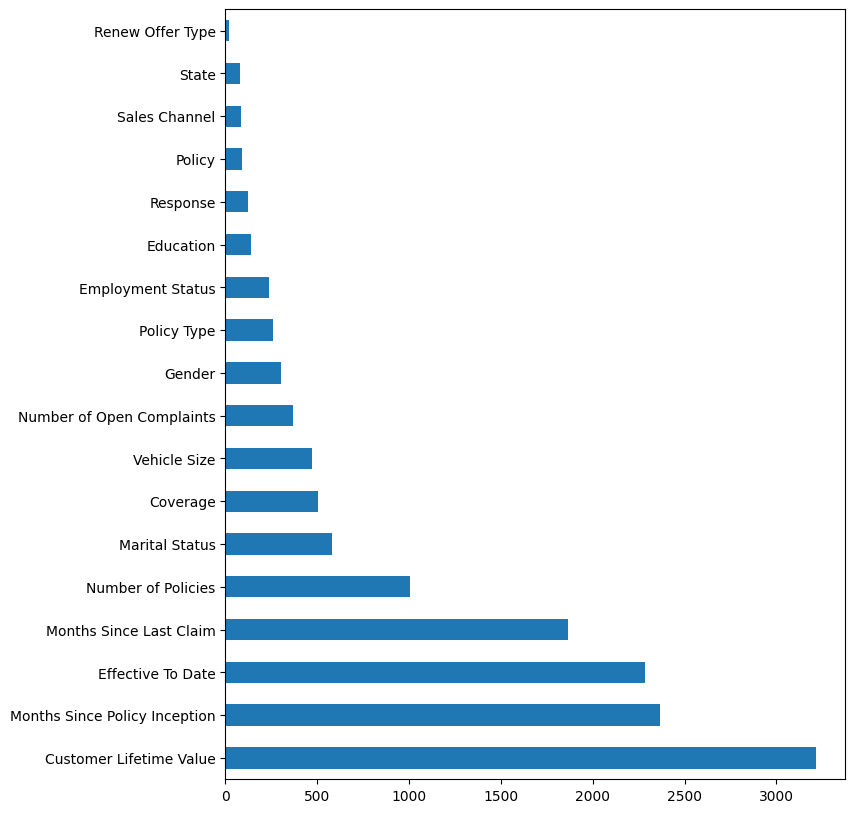

In [28]:
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


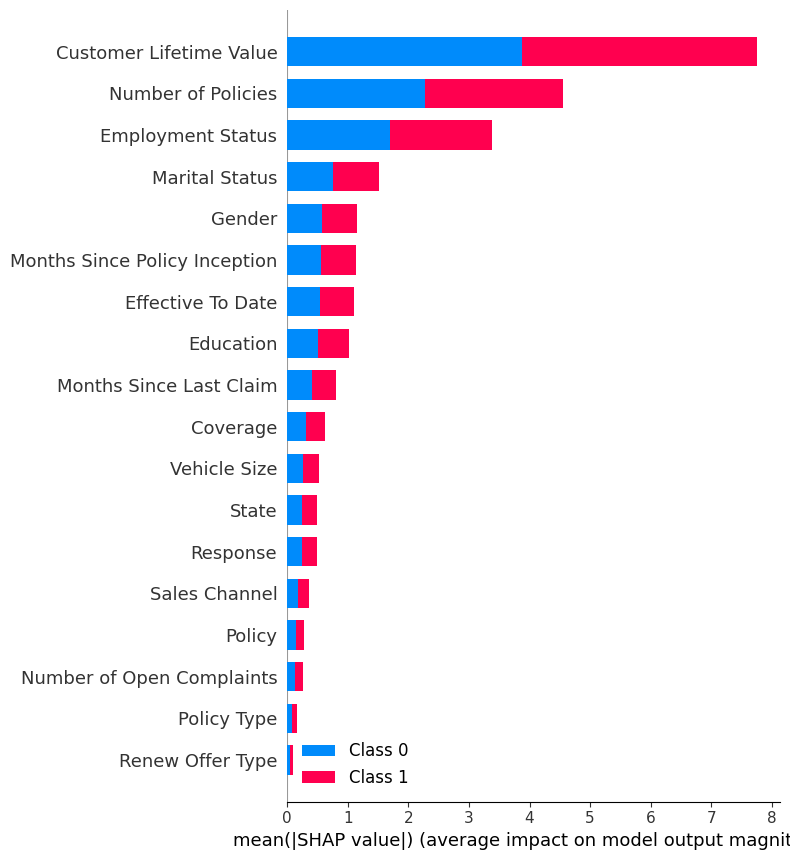

In [29]:
import shap
shap.initjs()

shap_values = shap.TreeExplainer(clf.booster_).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [30]:
# lgbm = LGBMClassifier(objective='binary', is_unbalance='true')
# lgbm.fit(train_X,train_y)
# val_y_predlgbm = lgbm.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [31]:
one_hot_encoded_testing_predictors = pd.get_dummies(test_predictors)
one_hot_encoded_testing_predictors

,Customer Lifetime Value,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Renew Offer Type
0,4008.95,36,38,0,1,2
1,8165.58,23,96,3,2,3
2,7210.94,5,15,1,7,1
3,6198.70,8,38,0,1,2
4,3570.32,20,61,0,1,1
...,...,...,...,...,...,...
1839,11851.77,41,93,0,1,3
1840,9438.68,20,9,1,4,4
1841,7026.27,45,107,0,6,1
1842,21968.20,36,88,0,2,3


In [32]:
# predictions = lgbm.predict(one_hot_encoded_testing_predictors)
# output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
# output.to_csv('submission.csv', index=False)